In [1]:
import os
import random
import torch
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import random
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter 

In [ ]:
# path to chexpert dataset with structure outlined in the project description
data_path = '/data'

train_csv_path = data_path + '/chexpert/v1.0/train.csv'
valid_csv_path = data_path + '/chexpert/v1.0/valid.csv'
dir_path = data_path + '/chexpert/v1.0/'

#path to the directory with saved state dictionaries
model_path = '/saves'

In [3]:
np.random.seed(2020)
torch.manual_seed(2020)

In [4]:
# data pre-processing, combining training set and test set, only use frontal images.
train_csv = pd.read_csv(train_csv_path, sep=',').fillna(0)
valid_csv = pd.read_csv(valid_csv_path, sep=',').fillna(0)
train_csv = train_csv[~train_csv[train_csv.columns[3]].str.contains("Lateral")]
valid_csv = valid_csv[~valid_csv[valid_csv.columns[3]].str.contains("Lateral")]

#this image is lost
pa = 'CheXpert-v1.0/train/patient40761/study1/view1_frontal.jpg'
train_csv = train_csv[~train_csv[train_csv.columns[0]].str.contains(pa)]

# drop other information 
train_csv = train_csv.drop(['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], axis=1)
valid_csv = valid_csv.drop(['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], axis=1)


In [5]:
train_csv.head(8)

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0/train/patient00001/study1/view1_...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CheXpert-v1.0/train/patient00004/study1/view1_...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CheXpert-v1.0/train/patient00005/study1/view1_...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,CheXpert-v1.0/train/patient00005/study2/view1_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10,CheXpert-v1.0/train/patient00005/study2/view2_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
# data visulization
labels_name = train_csv.columns[1:].values
labels_name

array(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
       'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
       'Pleural Other', 'Fracture', 'Support Devices'], dtype=object)

# Transforms

In [9]:
normMean = [0.50237626, 0.50237626, 0.502376264]
normStd = [0.24580306, 0.24236229, 0.2603115]
normTransform = transforms.Normalize(normMean, normStd)

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomRotation(7),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normTransform
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset and dataloader

Uncertain values are filled by uniformly distributed random numbers in range [0.55, 0.85] 

In [10]:
class Datasets(Dataset):
    
    def __init__(self, state, transform=None):
        self.path = state.iloc[1:,0].values
        labels = state.iloc[1:, 1:].values
        for row in range(labels.shape[0]):
            for column in range(labels.shape[1]):
                if labels[row][column] != 0.0 and labels[row][column] != 1.0:
                    labels[row][column] = round(np.random.uniform(0.55, 0.85), 2)
        self.labels = labels
        
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.path[index]
        img_path = img_path.replace('CheXpert-', 'chexpert/')
        image = Image.open(os.path.join(data_path, img_path)).convert('RGB')
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.FloatTensor(label)
            
    def __len__(self):
        return self.path.shape[0]

In [11]:
train_data = Datasets(train_csv, train_transform)
val_data = Datasets(valid_csv, test_transform)

# put it into dataloader
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Model

In [12]:
class Ensemble_model(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        super().__init__()
        
        # Load the DenseNet121, DenseNet169, DenseNet201, vgg19, vgg19_bn, mnasnet1_0
        self.net_1 = torchvision.models.densenet121(pretrained=is_trained)
        self.net_2 = torchvision.models.densenet169(pretrained=is_trained)
        self.net_3 = torchvision.models.densenet201(pretrained=is_trained)
        self.net_4 = torchvision.models.mnasnet1_0(pretrained=is_trained)
        self.net_5 = torchvision.models.vgg19_bn(pretrained=is_trained)
        self.net_6 = torchvision.models.vgg19(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count_1 = 1024
        kernel_count_2 = 1664
        kernel_count_3 = 1920
        kernel_count_4 = 1280
        kernel_count_5 = 25088
        kernel_count_6 = 25088
        
        #Remove last linear layer
        self.net_1.classifier = nn.Identity()
        self.net_2.classifier = nn.Identity()
        self.net_3.classifier = nn.Identity()
        self.net_4.classifier = nn.Identity()
        self.net_5.classifier = nn.Identity()
        self.net_6.classifier = nn.Identity()
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.classifier = nn.Sequential(nn.Linear(kernel_count_1 + kernel_count_2 + kernel_count_3 +\
                                                      kernel_count_4 + kernel_count_5 + kernel_count_6, num_classes), nn.Sigmoid())
        
    def forward(self, x):
        x1 = self.net_1(x.clone())  
        x1 = x1.view(x1.size(0), -1)
        
        x2 = self.net_2(x.clone())  
        x2 = x2.view(x2.size(0), -1)
        
        x3 = self.net_3(x.clone())  
        x3 = x3.view(x3.size(0), -1)
        
        x4 = self.net_4(x.clone())  
        x4 = x4.view(x4.size(0), -1)
        
        x5 = self.net_5(x.clone())  
        x5 = x5.view(x5.size(0), -1)
        
        x6 = self.net_6(x)  
        x6 = x6.view(x6.size(0), -1)
        
        x_all = torch.cat((x1, x2, x3, x4, x5, x6), dim=1)
        

        return self.classifier(x_all)

In [ ]:
model = Ensemble_model(14).cuda()

# Loss function, optimizer and scheduler

In [13]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, betas=(0.9, 0.999))
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1, last_epoch=-1)

Pick 5 target diseases

In [17]:
target = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
target_index = [list(labels_name).index(item) for item in target]
target_index

[8, 2, 6, 5, 10]

### Load state dictionary from previous epoch

For warm start load state dictionary in cell below and set epoch_start in next cell to corresponding epoch number

In [15]:
old = os.path.join(model_path, 'epoch-3_score-0.8458.pth' )
model.load_state_dict(torch.load(old))

<All keys matched successfully>

# Training

In [ ]:
target_scores = []
target_score_averages = []
new_scores = []

# use tensorboard to record
writer = SummaryWriter()

epoch_start = 4
num_epoch = 40
best_score = 0.0
for epoch in range(epoch_start, num_epoch):
    train_loss = 0.0
    val_loss = 0.0
    val_pred = torch.FloatTensor().cuda()     # Tensor stores prediction values
    val_label = torch.FloatTensor().cuda()       # Tensor stores true values
    
    model.train()
    
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        train_prd = model(data[0].cuda())
        batch_loss = loss(train_prd, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        # tensorboard for batch loss
        train_loss += batch_loss.item()
        index_train = len(train_loader) * epoch + i
        writer.add_scalar('batch_loss', batch_loss.item() , index_train)
    
    model.eval()
    with torch.no_grad():
        for j,data in enumerate(val_loader):
            prd = model(data[0].cuda())
            batch_loss = loss(prd, data[1].cuda())

            val_loss += batch_loss.item()
            val_pred = torch.cat((val_pred, prd), 0)
            val_label = torch.cat((val_label, data[1].cuda()), 0)
    
    learning_rate_scheduler.step()
    
    #tensorboard for score and train loss
    target_score = [roc_auc_score(val_label.cpu().numpy()[:, i], val_pred.detach().cpu().numpy()[:, i],average='macro', multi_class='ovo') for i in target_index]
    target_scores.append(target_score)
    target_score_average = roc_auc_score(val_label.cpu().numpy()[:, target_index], val_pred.detach().cpu().numpy()[:, target_index],average='macro', multi_class='ovo')
    target_score_averages.append(target_score_average)

    train_loss = train_loss/len(train_loader)
     
        
    if best_score < target_score_average:
        best_score = target_score_average.round(4)
        
        torch.save(model.state_dict(), os.path.join(model_path,f'epoch-{epoch}_score-{best_score}.pth'))
        
    writer.add_scalars('train/val for epochs', {'train_loss':np.array(train_loss), \
                                               'val_target':np.array(target_score_average)}, epoch)
writer.close()

# Evaluation

Load model weights file from directory model_path


In [ ]:
file_name = 'epoch-1_score-0.8407.pth'

In [27]:
target_scores = []
target_score_averages = []
valid_loss = []


model.load_state_dict(torch.load(os.path.join(model_path,f)))

val_pred = torch.FloatTensor().cuda()     # Tensor stores prediction values
val_label = torch.FloatTensor().cuda()       # Tensor stores true values

val_loss = 0.0
with torch.no_grad():
    for j,data in enumerate(val_loader):
                prd = model(data[0].cuda())
                batch_loss = loss(prd, data[1].cuda())

                val_loss += batch_loss.item()
                val_pred = torch.cat((val_pred, prd), 0)
                val_label = torch.cat((val_label, data[1].cuda()), 0)




target_score= [roc_auc_score(val_label.cpu().numpy()[:, i], val_pred.detach().cpu().numpy()[:, i],average='macro', multi_class='ovo') for i in target_index]
target_scores.append(target_score)
target_score_average = roc_auc_score(val_label.cpu().numpy()[:, target_index], val_pred.detach().cpu().numpy()[:, target_index],average='macro', multi_class='ovo')
target_score_averages.append(target_score_average)
val = val_loss/len(val_loader)
valid_loss.append(val)

In [29]:
target_scores, target_score_averages

([[0.8052910052910053,
   0.8143665158371042,
   0.9003328402366864,
   0.9203354297693922,
   0.9070483576642335]],
 [0.8694748297596844])

Text(0, 0.5, 'validation loss')

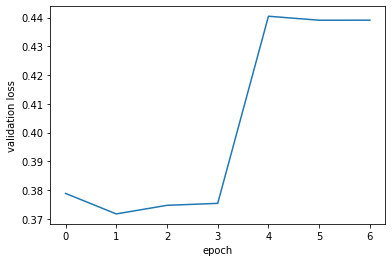

In [21]:
plt.plot(np.arange(7), valid_loss)
plt.xlabel('epoch')
plt.ylabel('validation loss')

Text(0, 0.5, 'auc_score')

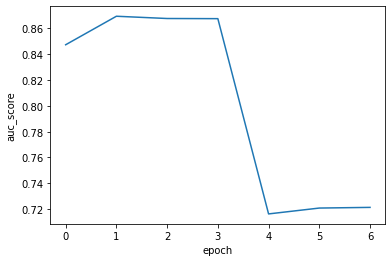

In [22]:
plt.plot(np.arange(7), target_score_averages)
plt.xlabel('epoch')
plt.ylabel('auc_score')